In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

sub_processes = 0

batch_size = 64

transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=sub_processes)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        
                              
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
                             
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
                             
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
                             
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
    
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        out = self.fc4(x)

        return out


In [5]:
class Generator(nn.Module):
                #         100         32           784
    def __init__(self, gen_in_size, gen_hidden, output_size):
        super(Generator, self).__init__()
        
      
        self.fc1 = nn.Linear(gen_in_size, gen_hidden)
        self.fc2 = nn.Linear(gen_hidden, gen_hidden*2)
        self.fc3 = nn.Linear(gen_hidden*2, gen_hidden*4)
        
        
        self.fc4 = nn.Linear(gen_hidden*4, output_size)
        
      
        self.dropout = nn.Dropout(0.3)

    def forward(self, fd):
      
        fd = F.leaky_relu(self.fc1(fd), 0.2) 
        fd = self.dropout(fd)
        fd = F.leaky_relu(self.fc2(fd), 0.2)
        fd = self.dropout(fd)
        fd = F.leaky_relu(self.fc3(fd), 0.2)
        fd = self.dropout(fd)
        
        out = F.tanh(self.fc4(fd))

        return out

In [6]:
in_size = 784

des_out_size = 1
des_hidd_size = 32




z_vector_size = 100
gen_out_size = 784
gen_hidd_size = 32



In [7]:
D = Discriminator(in_size, des_hidd_size, des_out_size)
G = Generator(z_vector_size, gen_hidd_size, gen_out_size)


print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [8]:
def real_loss(des_output, smooth=False):
    batch_size = des_output.size(0)
    
    if smooth:
        
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
        
  
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(des_output.squeeze(), labels)
    return loss

def fake_loss(des_output):
    batch_size = des_output.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(des_output.squeeze(), labels)
    return loss

In [9]:
import torch.optim as optim

lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [10]:
import pickle as pkl


number_of_epoch = 100


samples = []
losses = []

temp = 400


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_vector_size))
fixed_z = torch.from_numpy(fixed_z).float()


D.train()
G.train()
for epoch in range(number_of_epoch):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        
        real_images = real_images*2 - 1  
        
 
        
        d_optimizer.zero_grad()
        
  

      
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
       
        
       
        z = np.random.uniform(-1, 1, size=(batch_size, z_vector_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
               
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        
        g_optimizer.zero_grad()
        
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_vector_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
       
        g_loss.backward()
        g_optimizer.step()

        
        if batch_i % temp == 0:
            
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, number_of_epoch, d_loss.item(), g_loss.item()))

    
    
    losses.append((d_loss.item(), g_loss.item()))
    
    
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() 



with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

C:\Users\SARIM\Anaconda3\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3824 | g_loss: 0.7778
Epoch [    1/  100] | d_loss: 0.5121 | g_loss: 8.3060
Epoch [    1/  100] | d_loss: 1.2312 | g_loss: 1.1903
Epoch [    2/  100] | d_loss: 0.6812 | g_loss: 4.3278
Epoch [    2/  100] | d_loss: 1.0278 | g_loss: 1.3334
Epoch [    2/  100] | d_loss: 1.1047 | g_loss: 1.8730
Epoch [    3/  100] | d_loss: 1.1182 | g_loss: 1.2274
Epoch [    3/  100] | d_loss: 1.2448 | g_loss: 0.8847
Epoch [    3/  100] | d_loss: 1.0406 | g_loss: 1.1493
Epoch [    4/  100] | d_loss: 1.1300 | g_loss: 1.0924
Epoch [    4/  100] | d_loss: 1.2605 | g_loss: 1.0022
Epoch [    4/  100] | d_loss: 1.2439 | g_loss: 0.9683
Epoch [    5/  100] | d_loss: 1.1966 | g_loss: 1.2181
Epoch [    5/  100] | d_loss: 1.3584 | g_loss: 1.1578
Epoch [    5/  100] | d_loss: 1.1073 | g_loss: 1.6065
Epoch [    6/  100] | d_loss: 1.3549 | g_loss: 1.2382
Epoch [    6/  100] | d_loss: 1.1900 | g_loss: 0.9102
Epoch [    6/  100] | d_loss: 1.1180 | g_loss: 1.3672
Epoch [    7/  100] | d_loss

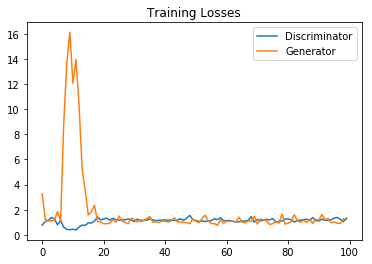

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [13]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

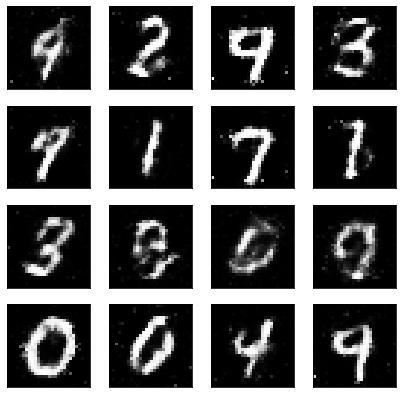

In [14]:
view_samples(-1, samples)

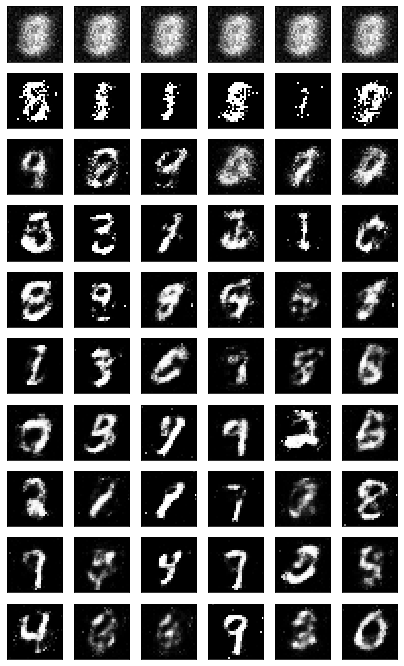

In [15]:
rows = 10 
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

input and output


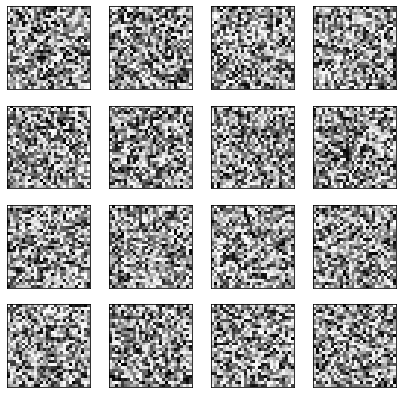

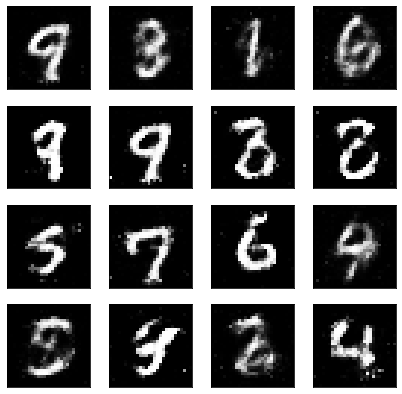

In [23]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() 
rand_images = G(rand_z)


rand_s = np.random.uniform(-1, 1, size=(sample_size, 784))
rand_s = torch.from_numpy(rand_s).float()
print("input and output")
view_samples(0, [rand_s])

view_samples(0, [rand_images])